In [51]:
import cv2
import numpy as np
import glob
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
%matplotlib inline
import PIL
import math
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

In [52]:
tf. __version__

'2.0.0'

In [53]:
def cutWorkSpace(img,border): 
    # dimensioni immagini
    img_h = 2048
    img_l = 2048
    # offset per posizionamento su area d'indagine
    offset_x = 600
    offset_y = 500
    
    #taglio per garantire la ricerca sull'area di interesse, evitando rumori dati dallo sfondo
    crop_img = img[offset_y:img_h-offset_y, offset_x:img_l-offset_x]
    
    # Convert the img to grayscale
    gray = cv2.cvtColor(crop_img,cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)
    high_thresh, thresh_im = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #cv2.imwrite('provaT.jpg', thresh_im)
    lowThresh = 0.5*high_thresh
    
    
    # Apply edge detection method on the image
    #edges = cv2.Canny(blurred,20,150,apertureSize = 3)
    edges = cv2.Canny(blurred,20,150,apertureSize = 3)
    #cv2.imwrite('canny.jpg', edges)
    # This returns an array of r and theta values
    lines = cv2.HoughLines(edges,1,np.pi/180, 100)
    #cv2.imwrite('Risultati/resFS'+name+'c.jpg', edges)
    # The below for loop runs till r and theta values 
    # are in the range of the 2d array
    i = 0
    x_first = 0
    x_second = 0
    count = 0
    delta = 30
    thetaFinal = 0
    while count < 2:
        for r,theta in lines[i]:
            # Stores the value of cos(theta) in a
            a = np.cos(theta)

            # Stores the value of sin(theta) in b
            b = np.sin(theta)

            # x0 stores the value rcos(theta)
            x0 = a*r

            # y0 stores the value rsin(theta)
            y0 = b*r

            #ti define line lenght
            const = 3000
            # x1 stores the rounded off value of (rcos(theta)-1000sin(theta))
            x1 = int(x0 + const*(-b))

            # y1 stores the rounded off value of (rsin(theta)+1000cos(theta))
            y1 = int(y0 + const*(a))

            # x2 stores the rounded off value of (rcos(theta)+1000sin(theta))
            x2 = int(x0 - const*(-b))

            # y2 stores the rounded off value of (rsin(theta)-1000cos(theta))
            y2 = int(y0 - const*(a))

            if count == 0 :
                if theta != 0:
                    thetaFinal = 180-math.degrees(theta)
                x_first = x0
                #cv2.line(img,(x1+offset_x,y1+offset_y), (x2+offset_x,y2+offset_y), (0,0,255),2)
                count += 1
            else:
                if abs(x_first-x0) > delta :
                    x_second = x0
                    #cv2.line(img,(x1+offset_x,y1+offset_y), (x2+offset_x,y2+offset_y), (0,0,255),2)
                    count += 1
            i += 1
    # All the changes made in the input image are finally
    # written on a new image houghlines.jpg
    #cv2.imwrite('Risultati/res'+name+'.jpg', img)
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # rotate our image by Theta degrees around the center of the image
    M = cv2.getRotationMatrix2D((cX, cY), -thetaFinal, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h))
    scale_percent = 30 # percent of original size

  
    if x_first < x_second:
        
        median = (x_second+x_first)//2
        temp = rotated[0:img_h-1, int(offset_x+median-border):int(offset_x+median+border)]
        width = int(temp.shape[1] * scale_percent / 100)
        height = int(temp.shape[0] * scale_percent / 100)
        dim = (width, height)
        temp = cv2.resize(temp, dim, interpolation = cv2.INTER_AREA)        
        gray = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)
        return  gray
    else:
        median = (x_first+x_second)//2.
        temp = rotated[0:img_h-1, int(offset_x+median-border):int(offset_x+median+border)]        
        #blurred = cv2.GaussianBlur(temp, (3,3), 0)
        width = int(temp.shape[1] * scale_percent / 100)
        height = int(temp.shape[0] * scale_percent / 100)
        dim = (width, height)
        temp = cv2.resize(temp, dim, interpolation = cv2.INTER_AREA)
        gray = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)
        return  gray
    

In [54]:
def divideImage(img,pcs):
    results = []
    lung = len(img) // pcs
    for i in range(pcs):
        results.append(img[(lung*i):(lung*(i+1)-1)][:])
    final_res = []
    for res in results:
        final_res.append(cv2.resize(res, (28,28), interpolation = cv2.INTER_AREA))
    return final_res

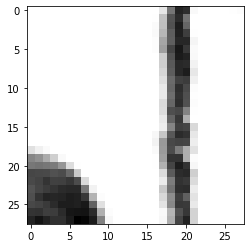

In [55]:
pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni/*.tif'
#pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'
pathFS = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScarti/*.tif'
#pathScarti = '/Users/leonardoaggio/Desktop/Dataset/S606C/Scarti/*.tif'
pathBuoniVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/BuoniVal/*.tif'
#pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'
pathFSVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScartiVal/*.tif'
pathScartiVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiVal/*.tif'

pezziXimmagine = 10
border = 60
#Nclusters = 10

#results = []
img_train = []
img_test = []


list_paths = []



list_paths = glob.glob(pathBuoni)
list_paths += glob.glob(pathFS) 
#list_paths += glob.glob(pathScarti) 

count = 0
for img_path in list_paths:
    img = cv2.imread(img_path)
    #try:
    img_train +=  divideImage(cutWorkSpace(img,border),pezziXimmagine)
    count += 1
    #except:
        #print('errore lettura')


list_paths = glob.glob(pathBuoniVal)
list_paths += glob.glob(pathFSVal) 
#list_paths += glob.glob(pathScartiVal) 

count = 0
for img_path in list_paths:
    img = cv2.imread(img_path)
    try:
        img_test +=  divideImage(cutWorkSpace(img,border),pezziXimmagine)
        count += 1
    except:
        print('errore lettura')



#####
# ORA HO IMG_RESULTS & RESULTS
plt.imshow(img_test[10])
plt.show()

In [56]:

x_train = np.array(img_train)

rows = 28
col = 28


x_train = x_train/255.
x_temp = np.empty((len(img_train), rows,col,1))
x_train = x_train.astype('float32')
for i in range(len(img_train)):
    x_temp[i]=(np.expand_dims(x_train[i], axis=2))
x_train = x_temp



x_temp = np.empty((len(img_train), rows,col,1))


x_temp = x_train.astype('float32')


x_test = np.array(img_test)
x_test = x_test/255.

x_temp = np.empty((len(img_test), rows,col,1))
for i in range(len(x_test)):
    x_temp[i]=(np.expand_dims(x_test[i], axis=2))
x_test = x_temp


x_train = x_train.astype('float32')

x_test = x_train.astype('float32')


In [57]:
x_test[0][0][0]

array([1.], dtype=float32)

In [58]:
x_train[0][0][0]

array([1.], dtype=float32)

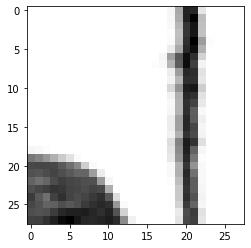

In [59]:
plt.imshow(x_test[10])
plt.show()

In [60]:
input_img = Input(shape=(28, 28, 1)) 

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)


In [61]:
def SSIMLoss(y_true, y_pred):
    
    y_true = tf.convert_to_tensor(y_true)
    y_pred = tf.convert_to_tensor(y_pred)

    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred,1.0))




In [72]:
autoencoder = tf.keras.Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(lr = 0.0005)
#mse = tf.keras.losses.MeanSquaredError()
autoencoder.compile(optimizer=optimizer, loss=SSIMLoss)


In [73]:
hist=autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test)
                )



Train on 1720 samples, validate on 1720 samples
Epoch 1/10
1720/1720 [==============================] - 11s 6ms/sample - loss: 0.1540 - val_loss: 0.8458
Epoch 2/10
1720/1720 [==============================] - 7s 4ms/sample - loss: 0.0927 - val_loss: 0.8556
Epoch 3/10
1720/1720 [==============================] - 7s 4ms/sample - loss: 0.0980 - val_loss: 0.8531
Epoch 4/10
1720/1720 [==============================] - 8s 5ms/sample - loss: 0.0763 - val_loss: 0.8472
Epoch 5/10
1720/1720 [==============================] - 7s 4ms/sample - loss: 0.1086 - val_loss: 0.8444
Epoch 6/10
1720/1720 [==============================] - 7s 4ms/sample - loss: 0.0603 - val_loss: 0.8334
Epoch 7/10
1720/1720 [==============================] - 7s 4ms/sample - loss: 0.0524 - val_loss: 0.8290
Epoch 8/10
1720/1720 [==============================] - 7s 4ms/sample - loss: 0.0488 - val_loss: 0.8218
Epoch 9/10
1720/1720 [==============================] - 7s 4ms/sample - loss: 0.0499 - val_loss: 0.8191
Epoch 10/10
172

In [ ]:
autoencoder.save('autoencoder28x28_2')

In [ ]:
autoencoder_copy = tf.keras.models.load_model('autoencoder28x28_2', compile=False)
autoencoder_copy.compile(optimizer=optimizer, loss=SSIMLoss)

In [74]:
autoencoder_copy = autoencoder

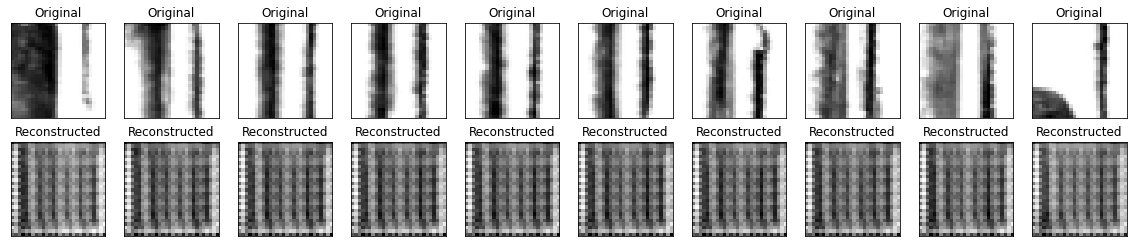

In [75]:
decoded_imgs = autoencoder_copy.predict(x_train)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    plt.title("Original")
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.title("Reconstructed")
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [42]:
values1 = []

for i in range(len(x_train)):
    print(str(i)+'/'+str(len(x_train)))
    value_a = SSIMLoss(x_train[i],decoded_imgs[i])
    values1.append(value_a.numpy())

0/1720
1/1720
2/1720
3/1720
4/1720
5/1720
6/1720
7/1720
8/1720
9/1720
10/1720
11/1720
12/1720
13/1720
14/1720
15/1720
16/1720
17/1720
18/1720
19/1720
20/1720
21/1720
22/1720
23/1720
24/1720
25/1720
26/1720
27/1720
28/1720
29/1720
30/1720
31/1720
32/1720
33/1720
34/1720
35/1720
36/1720
37/1720
38/1720
39/1720
40/1720
41/1720
42/1720
43/1720
44/1720
45/1720
46/1720
47/1720
48/1720
49/1720
50/1720
51/1720
52/1720
53/1720
54/1720
55/1720
56/1720
57/1720
58/1720
59/1720
60/1720
61/1720
62/1720
63/1720
64/1720
65/1720
66/1720
67/1720
68/1720
69/1720
70/1720
71/1720
72/1720
73/1720
74/1720
75/1720
76/1720
77/1720
78/1720
79/1720
80/1720
81/1720
82/1720
83/1720
84/1720
85/1720
86/1720
87/1720
88/1720
89/1720
90/1720
91/1720
92/1720
93/1720
94/1720
95/1720
96/1720
97/1720
98/1720
99/1720
100/1720
101/1720
102/1720
103/1720
104/1720
105/1720
106/1720
107/1720
108/1720
109/1720
110/1720
111/1720
112/1720
113/1720
114/1720
115/1720
116/1720
117/1720
118/1720
119/1720
120/1720
121/1720
122/1720
123

KeyboardInterrupt: 

In [ ]:
min(values1)

In [75]:
decoded_imgs = autoencoder_copy.predict(x_test)

In [77]:
values1 = []

for i in range(len(x_test)):
    print(str(i)+'/'+str(len(x_test)))


    value_a = SSIMLoss(x_test[i],decoded_imgs[i])
    values1.append(value_a.numpy())

0/1720
1/1720
2/1720
3/1720
4/1720
5/1720
6/1720
7/1720
8/1720
9/1720
10/1720
11/1720
12/1720
13/1720
14/1720
15/1720
16/1720
17/1720
18/1720
19/1720
20/1720
21/1720
22/1720
23/1720
24/1720
25/1720
26/1720
27/1720
28/1720
29/1720
30/1720
31/1720
32/1720
33/1720
34/1720
35/1720
36/1720
37/1720
38/1720
39/1720
40/1720
41/1720
42/1720
43/1720
44/1720
45/1720
46/1720
47/1720
48/1720
49/1720
50/1720
51/1720
52/1720
53/1720
54/1720
55/1720
56/1720
57/1720
58/1720
59/1720
60/1720
61/1720
62/1720
63/1720
64/1720
65/1720
66/1720
67/1720
68/1720
69/1720
70/1720
71/1720
72/1720
73/1720
74/1720
75/1720
76/1720
77/1720
78/1720
79/1720
80/1720
81/1720
82/1720
83/1720
84/1720
85/1720
86/1720
87/1720
88/1720
89/1720
90/1720
91/1720
92/1720
93/1720
94/1720
95/1720
96/1720
97/1720
98/1720
99/1720
100/1720
101/1720
102/1720
103/1720
104/1720
105/1720
106/1720
107/1720
108/1720
109/1720
110/1720
111/1720
112/1720
113/1720
114/1720
115/1720
116/1720
117/1720
118/1720
119/1720
120/1720
121/1720
122/1720
123

In [92]:
path = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'
#path = 'Desktop/Dataset/S606C/ScartiTotali/' 
pezziXimmagine = 22
border = 100
#Nclusters = 10

#results = []
imgs = []


list_paths = []

list_paths += glob.glob(path) 
count = 0
for img_path in list_paths:
    img = cv2.imread(img_path)
    try:
        temp = cutWorkSpace(img,border)
        imgs +=  divideImage(temp,pezziXimmagine)
        #plt.imshow(temp)
        #plt.show()
        count += 1
    except:
        print('errore lettura')



        
x_test_final = np.array(img_test)
x_test_final = x_test_final/255.       


x_temp = np.empty((len(imgs), rows,col,1))

for i in range(len(imgs)):
    x_temp[i]=(np.expand_dims(x_test_final[i], axis=2))
x_test_final = x_temp


x_test_final = x_test_final.astype('float32')



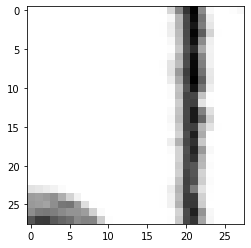

In [94]:
plt.imshow(x_test_final[0])
plt.show()

In [95]:
decoded_imgs_final = autoencoder_copy.predict(x_test_final)

In [96]:
values2 = []

for i in range(len(x_test_final)):
    print(str(i)+ ' su '+ str(len(x_test_final)))
    value_a = SSIMLoss(x_test_final[i],decoded_imgs_final[i])
    values2.append(value_a.numpy())

0 su 198
1 su 198
2 su 198
3 su 198
4 su 198
5 su 198
6 su 198
7 su 198
8 su 198
9 su 198
10 su 198
11 su 198
12 su 198
13 su 198
14 su 198
15 su 198
16 su 198
17 su 198
18 su 198
19 su 198
20 su 198
21 su 198
22 su 198
23 su 198
24 su 198
25 su 198
26 su 198
27 su 198
28 su 198
29 su 198
30 su 198
31 su 198
32 su 198
33 su 198
34 su 198
35 su 198
36 su 198
37 su 198
38 su 198
39 su 198
40 su 198
41 su 198
42 su 198
43 su 198
44 su 198
45 su 198
46 su 198
47 su 198
48 su 198
49 su 198
50 su 198
51 su 198
52 su 198
53 su 198
54 su 198
55 su 198
56 su 198
57 su 198
58 su 198
59 su 198
60 su 198
61 su 198
62 su 198
63 su 198
64 su 198
65 su 198
66 su 198
67 su 198
68 su 198
69 su 198
70 su 198
71 su 198
72 su 198
73 su 198
74 su 198
75 su 198
76 su 198
77 su 198
78 su 198
79 su 198
80 su 198
81 su 198
82 su 198
83 su 198
84 su 198
85 su 198
86 su 198
87 su 198
88 su 198
89 su 198
90 su 198
91 su 198
92 su 198
93 su 198
94 su 198
95 su 198
96 su 198
97 su 198
98 su 198
99 su 198
100 su 198

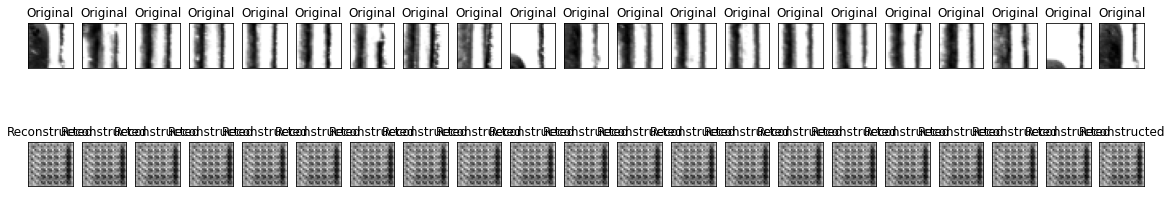

In [98]:
#decoded_imgs = autoencoder_copy.predict(x_test_final)
n = 21
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_final[i].reshape(rows, col))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    plt.title("Original")
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.title("Reconstructed")
    plt.imshow(decoded_imgs_final[i].reshape(rows, col))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [115]:
values2

[1.0175086,
 1.0311874,
 1.0075125,
 1.004692,
 1.0246489,
 1.0500087,
 1.0312415,
 1.0328605,
 0.9917791,
 0.9918529,
 1.0108204,
 1.0145874,
 1.0791835,
 1.0446404,
 1.0781046,
 1.0801413,
 1.0868727,
 1.0611428,
 1.0604335,
 1.0475909,
 0.97748667,
 0.95663416,
 0.9230342,
 0.97290057,
 0.9492872,
 0.950679,
 0.97136414,
 0.9594917,
 0.9664671,
 1.0117545,
 1.032509,
 1.0235187,
 0.92935216,
 0.9771148,
 0.9545755,
 0.9018529,
 0.9648971,
 0.9728144,
 1.0193672,
 1.0374435,
 0.9960011,
 1.0062367,
 0.96491647,
 1.0105741,
 1.0023867,
 0.9998652,
 1.0039672,
 0.97711885,
 1.000639,
 1.054032,
 1.0063969,
 0.97694737,
 0.976908,
 1.0159793,
 0.9996687,
 1.0046662,
 1.0076666,
 0.97666115,
 0.98007405,
 1.0466398,
 1.0437827,
 1.0339767,
 0.92207026,
 0.9919713,
 1.0036296,
 0.9858048,
 0.99560183,
 1.0117667,
 0.9474143,
 1.0512184,
 1.0244199,
 1.0031325,
 1.0077244,
 1.0211285,
 1.0126371,
 1.0001336,
 1.0128509,
 1.0254312,
 1.0996697,
 1.0680496,
 0.9725936,
 0.93288684,
 0.971794

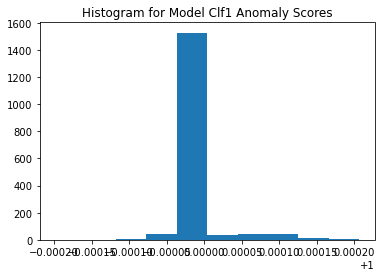

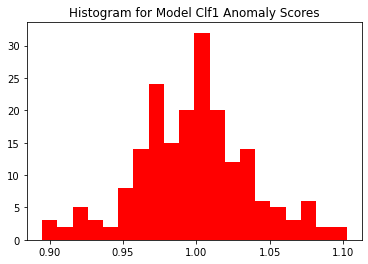

1.102452


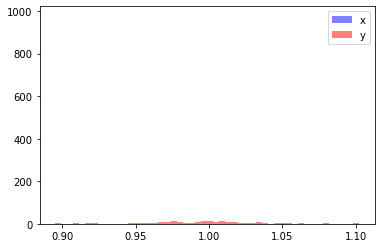

In [113]:
plt.hist(values1, bins=10)  # arguments are passed to np.histogram
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.show()

#print(np.min(values1))

plt.hist(values2, bins=20, color='r')  # arguments are passed to np.histogram
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.show()

print(np.max(values2))

x = values1
y = values2


plt.hist(x, bins=50, alpha=0.5, label='x', color='b')
plt.hist(y, bins=50, alpha=0.5, label='y', color = 'r')
plt.legend(loc='upper right')
plt.show()

